# Loveida Lucero

# **Task:** Help Chicago law allocate resources for the next 6 months. 

**Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob 
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)

## Customization Options,
#plt.style.use(('fivethirtyeight'))
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'
sns.set_context('notebook', font_scale=1.2)

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

**Custom Functions**

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.set_ylabel('Home Value')
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
import matplotlib.dates as mdates
def plot_seasonal(seasonal):
    minor_loc = mdates.MonthLocator()
    fig, ax = plt.subplots()
    ax.plot(seasonal)
    ax.set(title='Seasonal Component for New York');
    ax.xaxis.set_minor_locator(minor_loc)
    ax.grid(which='major', axis='x',lw=1, color='k')
    ax.grid(which='minor',axis='x',lw=0.5)
    fig.autofmt_xdate(rotation=90, ha='center')

    return fig, ax

In [7]:
# Use glob to get all filepaths that match the pattern 
crime_files = sorted(glob.glob("Data/Chicago-Crime_*.csv"))
crime_files

['Data\\Chicago-Crime_2001.csv',
 'Data\\Chicago-Crime_2002.csv',
 'Data\\Chicago-Crime_2003.csv',
 'Data\\Chicago-Crime_2004.csv',
 'Data\\Chicago-Crime_2005.csv',
 'Data\\Chicago-Crime_2006.csv',
 'Data\\Chicago-Crime_2007.csv',
 'Data\\Chicago-Crime_2008.csv',
 'Data\\Chicago-Crime_2009.csv',
 'Data\\Chicago-Crime_2010.csv',
 'Data\\Chicago-Crime_2011.csv',
 'Data\\Chicago-Crime_2012.csv',
 'Data\\Chicago-Crime_2013.csv',
 'Data\\Chicago-Crime_2014.csv',
 'Data\\Chicago-Crime_2015.csv',
 'Data\\Chicago-Crime_2016.csv',
 'Data\\Chicago-Crime_2017.csv',
 'Data\\Chicago-Crime_2018.csv',
 'Data\\Chicago-Crime_2019.csv',
 'Data\\Chicago-Crime_2020.csv',
 'Data\\Chicago-Crime_2021.csv',
 'Data\\Chicago-Crime_2022.csv']

In [8]:
# Use read_csv in a list comprehension and combine with concat to load all files
df = pd.concat([pd.read_csv(f) for f in crime_files])
df.reset_index()

,index,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713104,238853,12938029,12/31/2022 12:50:00 PM,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966
7713105,238854,12937822,12/31/2022 12:50:00 PM,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669
7713106,238855,12937583,12/31/2022 12:52:00 AM,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098
7713107,238856,12938420,12/31/2022 12:52:00 PM,ASSAULT,SIMPLE,COMMERCIAL / BUSINESS OFFICE,False,False,1432,14.0,32.0,41.930693,-87.685657


In [9]:
# convert date column to datetime
date_format = '%m/%d/%Y %I:%M:%S %p'
df['Date'] = pd.to_datetime(df['Date'],format=date_format)

In [10]:
# set date as index
df = df.set_index('Date')

In [11]:
df = df.sort_index()

In [12]:
# groupy by crime/year and display counts
df_month = df.groupby('Primary Type').resample('MS').size()
df_month

Primary Type       Date      
ARSON              2001-01-01     67
                   2001-02-01     57
                   2001-03-01     93
                   2001-04-01     89
                   2001-05-01     94
                                ... 
WEAPONS VIOLATION  2022-08-01    832
                   2022-09-01    780
                   2022-10-01    735
                   2022-11-01    597
                   2022-12-01    543
Length: 8602, dtype: int64

In [13]:
# unstack crimes to display counts each year
unstacked = df_month.unstack(level=0)
unstacked

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,67.0,2123.0,6527.0,1934.0,NaN,162.0,3966.0,3.0,1192.0,1398.0,...,2800.0,563.0,NaN,161.0,2.0,1396.0,218.0,26.0,7867.0,337.0
2001-02-01,57.0,2029.0,6042.0,1666.0,NaN,134.0,3665.0,1.0,1063.0,1163.0,...,2488.0,426.0,1.0,173.0,0.0,1159.0,149.0,13.0,6669.0,301.0
2001-03-01,93.0,2824.0,7662.0,1832.0,NaN,149.0,4617.0,4.0,1141.0,1313.0,...,2836.0,550.0,0.0,267.0,2.0,1399.0,184.0,17.0,7766.0,345.0
2001-04-01,89.0,2746.0,8328.0,1932.0,NaN,132.0,4922.0,2.0,1133.0,1199.0,...,2483.0,564.0,1.0,229.0,1.0,1341.0,169.0,29.0,7702.0,321.0
2001-05-01,94.0,2903.0,8887.0,1997.0,1.0,155.0,4757.0,2.0,1067.0,1261.0,...,2528.0,503.0,1.0,239.0,1.0,1491.0,227.0,12.0,8420.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,40.0,1984.0,3740.0,674.0,15.0,NaN,2713.0,145.0,392.0,1432.0,...,1214.0,23.0,1.0,56.0,NaN,749.0,127.0,48.0,5244.0,832.0
2022-09-01,49.0,1891.0,3723.0,653.0,13.0,NaN,2619.0,144.0,378.0,1540.0,...,1147.0,59.0,1.0,66.0,NaN,868.0,116.0,33.0,5117.0,780.0
2022-10-01,41.0,1839.0,3501.0,688.0,10.0,NaN,2834.0,162.0,374.0,1568.0,...,1166.0,26.0,1.0,72.0,NaN,945.0,91.0,46.0,5242.0,735.0


# **THEFT**

In [14]:
# define time series for theft
ts_theft = unstacked['THEFT']
ts_theft

Date
2001-01-01    7867.0
2001-02-01    6669.0
2001-03-01    7766.0
2001-04-01    7702.0
2001-05-01    8420.0
               ...  
2022-08-01    5244.0
2022-09-01    5117.0
2022-10-01    5242.0
2022-11-01    4717.0
2022-12-01    4413.0
Name: THEFT, Length: 264, dtype: float64

In [15]:
# check for nulls
ts_theft.isna().sum().sum()

0

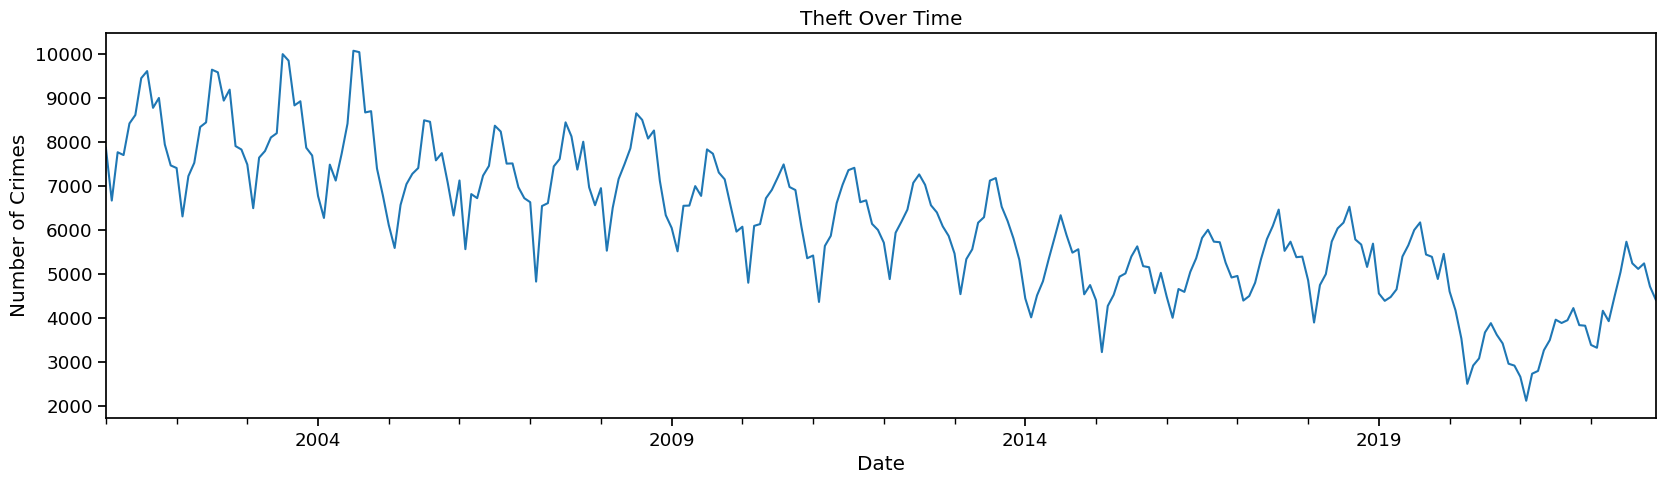

In [44]:
ts_theft.plot(ylabel='Number of Crimes', title='Theft Over Time');

## Seasonality

In [16]:
decomp = tsa.seasonal_decompose(ts_theft)
decomp

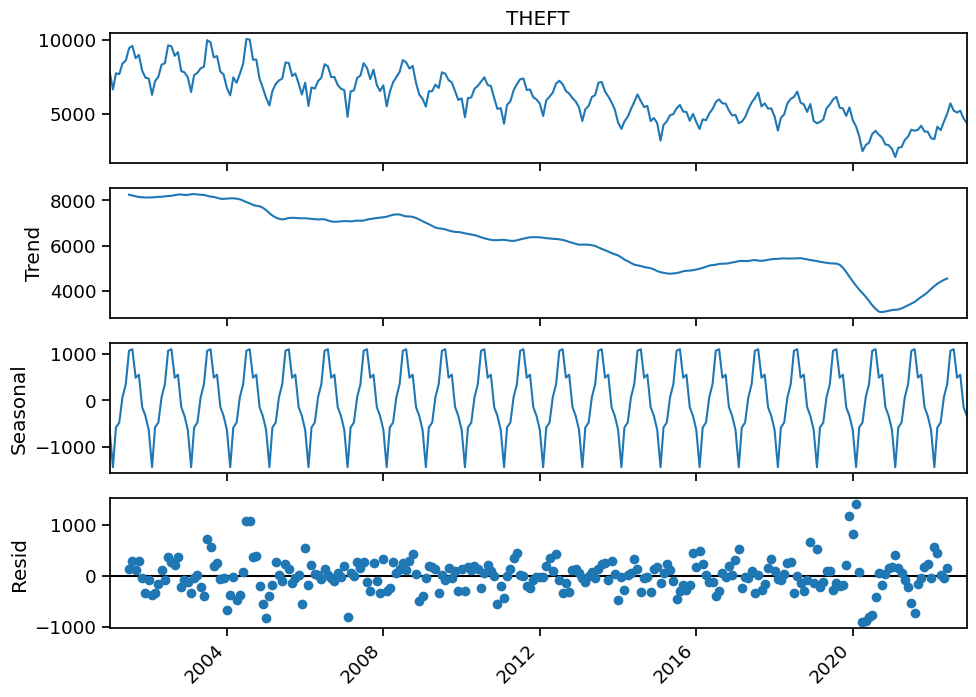

In [17]:
# vizualize decomp
plt.rcParams['figure.figsize']=(10,8)

fig = decomp.plot()

fig.tight_layout()
fig.autofmt_xdate(which='major', rotation=45);

In [18]:
from scipy.signal import find_peaks
seasonal = decomp.seasonal
peaks, props = find_peaks(seasonal, height=seasonal.max())

In [19]:
peak_dates = seasonal.index[peaks]
peak_dates

DatetimeIndex(['2001-08-01', '2002-08-01', '2003-08-01', '2004-08-01',
               '2005-08-01', '2006-08-01', '2007-08-01', '2008-08-01',
               '2009-08-01', '2010-08-01', '2011-08-01', '2012-08-01',
               '2013-08-01', '2014-08-01', '2015-08-01', '2016-08-01',
               '2017-08-01', '2018-08-01', '2019-08-01', '2020-08-01',
               '2021-08-01', '2022-08-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [20]:
period = peak_dates[1] - peak_dates[0]
period

Timedelta('365 days 00:00:00')

In [21]:
periods = []
for i in range(len(peak_dates)-1):
    delta = peak_dates[i+1] - peak_dates[i]
    periods.append(delta)
periods

[Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('366 days 00:00:00'),
 Timedelta('365 days 00:00:00'),
 Timedelta('365 days 00:00:00')]

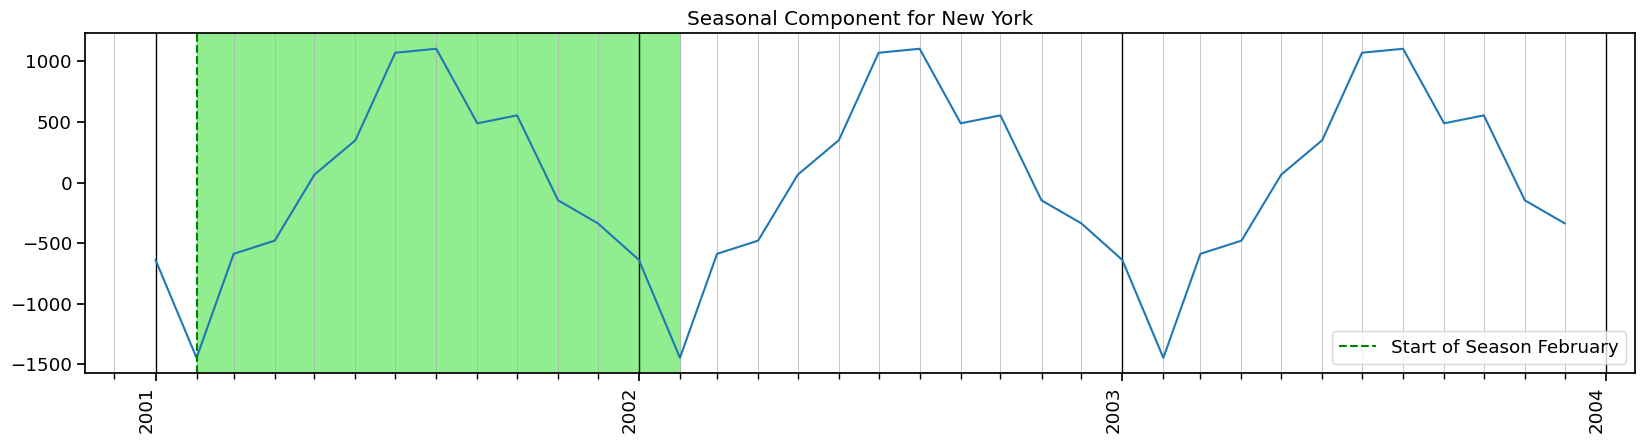

In [36]:
plt.rcParams['figure.figsize']=(20,5)

fig, ax = plot_seasonal(seasonal.loc['2001':'2003'])
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_locator(mdates.YearLocator(1))
plt.xticks(rotation=90, ha='right')
season_start = seasonal.idxmin()
ax.axvspan( season_start, season_start +period, color='lightgreen')
ax.axvline(season_start, color='green', ls='--',
           label=f"Start of Season {season_start.strftime('%B')}")
ax.legend();

In [23]:
seasonal.max() - seasonal.min()

2549.9880952380954

The seasonality is has a clear rise and fall and with a range of ~2,550 crimes the seasonality will be factored into the model.

In [26]:
# tsa.adfuller(df)
get_adfuller_results(ts_theft)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.393935,13,250,0.58518,0.05,False


In [38]:
# obtain diff number
d = ndiffs(ts_theft)
D = nsdiffs(ts_theft, m=12)

d,D

(1, 0)

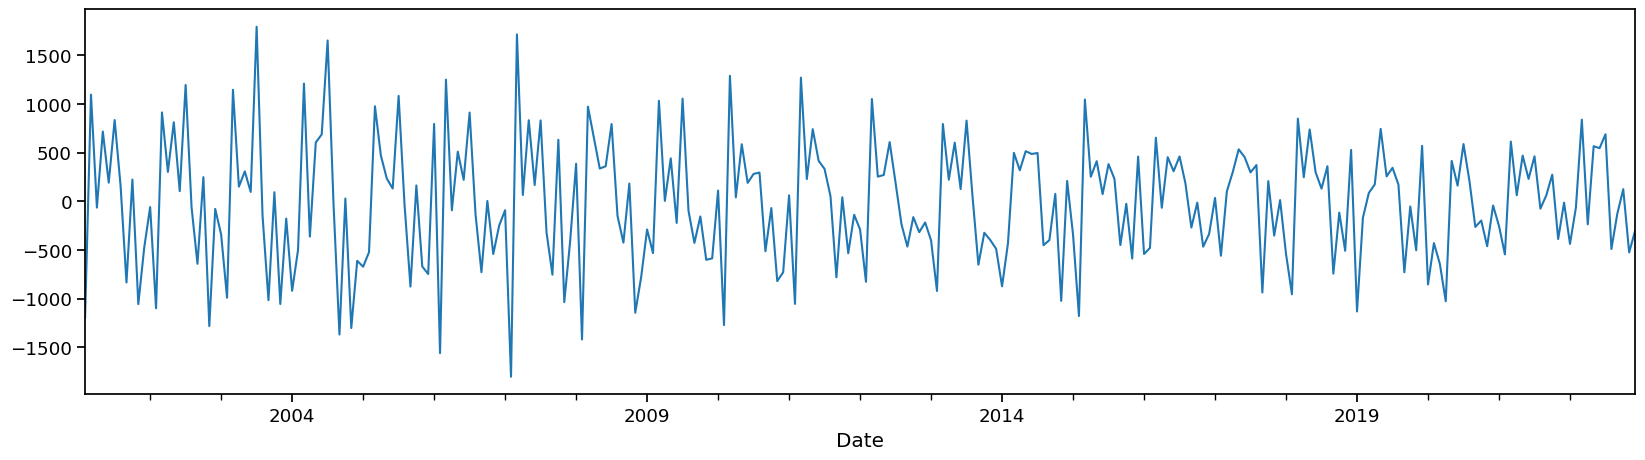

In [30]:
# get diff values
ts_diff = ts_theft.diff()
ts_diff = ts_diff.dropna()

ts_diff.plot();

In [31]:
# confirm 2diff is stationary
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-3.953728,12,250,0.001673,0.05,True


## ACF and PACF

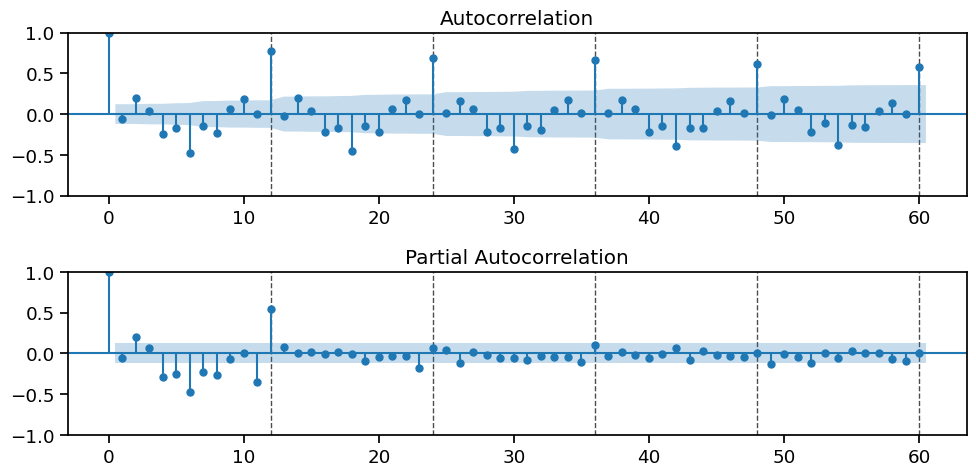

In [41]:
# plot acf to determine p,q,d
plot_acf_pacf(ts_diff,
              m=12,
              pacf_kws={'method': 'ywm'},
              annotate_seas=True,
              nlags=60);

There are no clear cutoffs or gradual decay but there is an obvious seasonality. Multiple orders will be tested using the defined d, D values already defined.

## Train Test Split

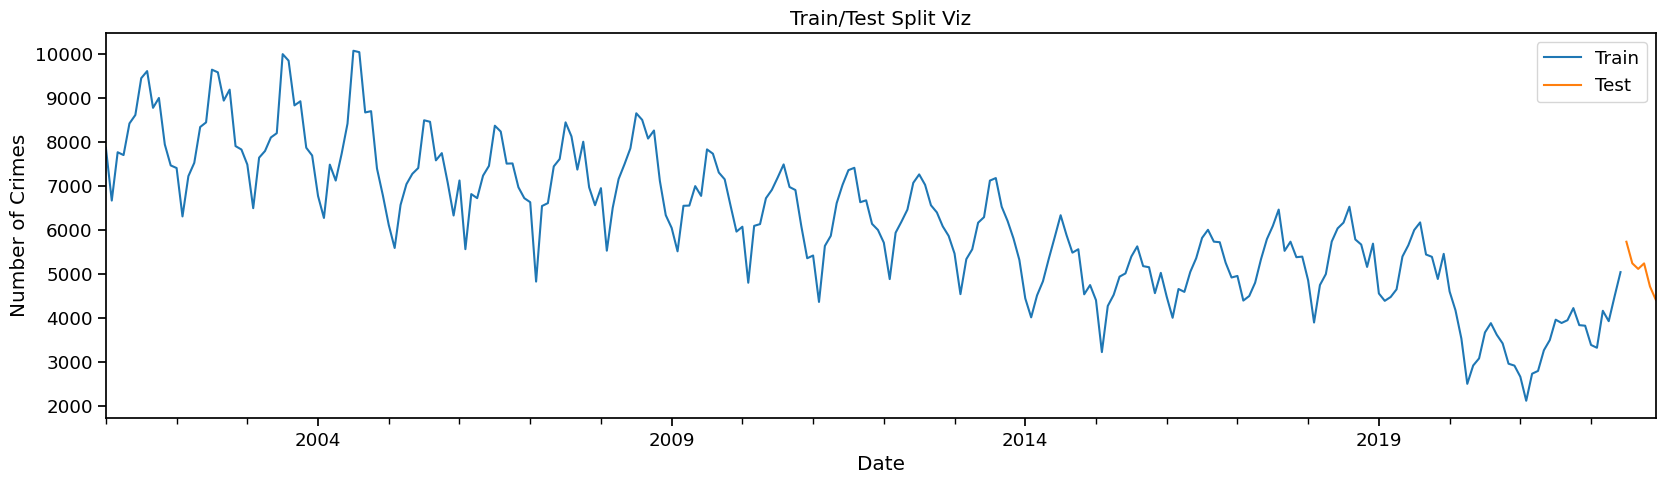

In [45]:
# Split the time series into training and test data (Remember we want to predict 6 months)
train, test = train_test_split(ts_theft, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.set_ylabel('Number of Crimes')
ax.set_title('Train/Test Split Viz')
ax.legend();

## Fit Manual ARIMA/SARIMA Model

In [72]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

P = 1
D = 0
Q = 1
m = 12


auto_sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order = (P,D,Q,m)).fit()  

# Obtain model summary
auto_sarima.summary()

C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  258
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1875.420
Date:                          Thu, 30 Nov 2023   AIC                           3760.840
Time:                                  21:39:58   BIC                           3778.586
Sample:                              01-01-2001   HQIC                          3767.977
                                   - 06-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9990      0.346      2.891      0.004       0.322       1.676
ma.L1         -0.9990      0.444     -2.249      0.025      -1.870      -0.128
ar.S.L12       0.9711      0.008    116.362      0.000       0.955       0.987
ma.S.L12      -0.7062      0.040    -17.686      0.000      -0.784      -0.628
sigma2      1.088e+05   1.14e+04      9.552      0.000    8.65e+04    1.31e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.73   Jarque-Bera (JB):                12.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.27
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

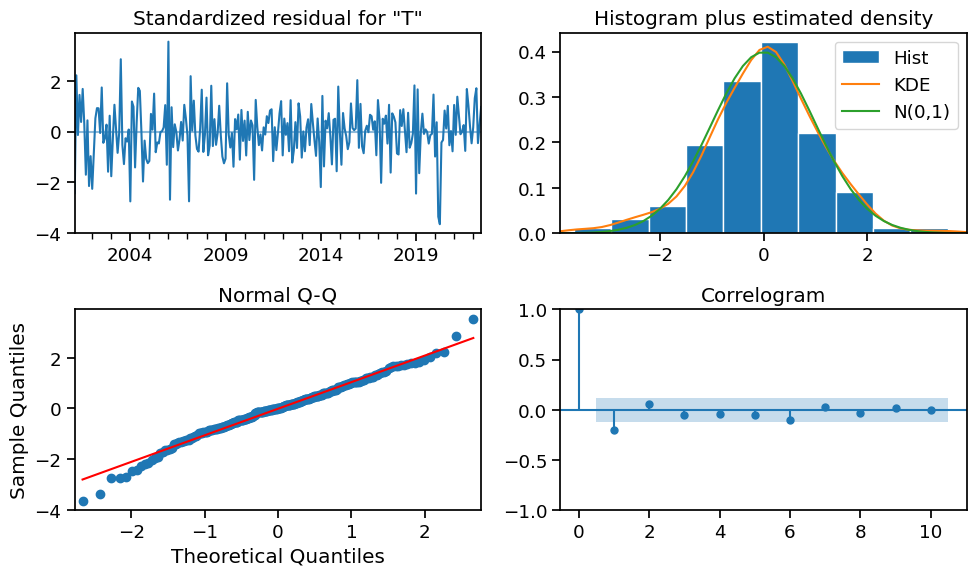

In [73]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 214.220
- MSE = 73,401.448
- RMSE = 270.927
- R^2 = 0.584
- MAPE = 4.34%


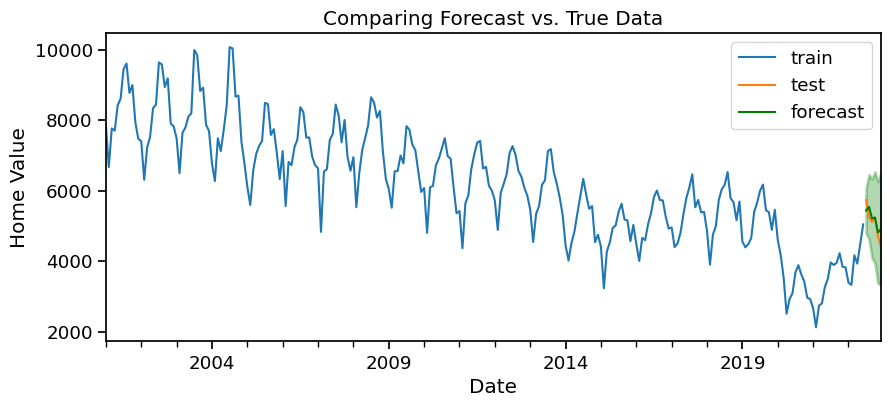

In [74]:
# Obtain summary of forecast as dataframe
forecast_df = auto_sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

## Fit Tuned ARIMA/SARIMA

In [75]:
import pmdarima as pm

# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    d=2,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=4223.623, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=3890.570, Time=0.25 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=4093.852, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=3871.273, Time=0.51 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=3848.015, Time=1.91 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=3847.342, Time=0.55 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=3981.642, Time=0.19 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=3847.658, Time=1.17 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=3944.201, Time=0.57 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=inf, Time=3.68 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=3963.130, Time=0.25 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=3815.309, Time=0.58 sec
 ARIMA(2,2,0)(0,0,1)[12]          

In [76]:
auto_sarima = tsa.ARIMA(train, order = auto_model.order, seasonal_order=auto_model.seasonal_order).fit()  

# Obtain model summary
auto_sarima.summary()

C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 THEFT   No. Observations:                  258
Model:             ARIMA(2, 2, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -1900.991
Date:                               Thu, 30 Nov 2023   AIC                           3813.982
Time:                                       21:42:04   BIC                           3835.253
Sample:                                   01-01-2001   HQIC                          3822.537
                                        - 06-01-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7975      0.049    -16.196      0.000      -0.894      -0.701
ar.L2         -0.3454      0.054     -6.382      0.000      -0.451      -0.239
ar.S.L12       0.9682      0.012     81.968      0.000       0.945       0.991
ma.S.L12      -0.5792      0.059     -9.747      0.000      -0.696      -0.463
ma.S.L24      -0.1242      0.065     -1.920      0.055      -0.251       0.003
sigma2      1.473e+05   1.35e+04     10.925      0.000    1.21e+05    1.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.17   Prob(JB):                         0.93
Heteroskedasticity (H):               0.71   Skew:                            -0.06
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

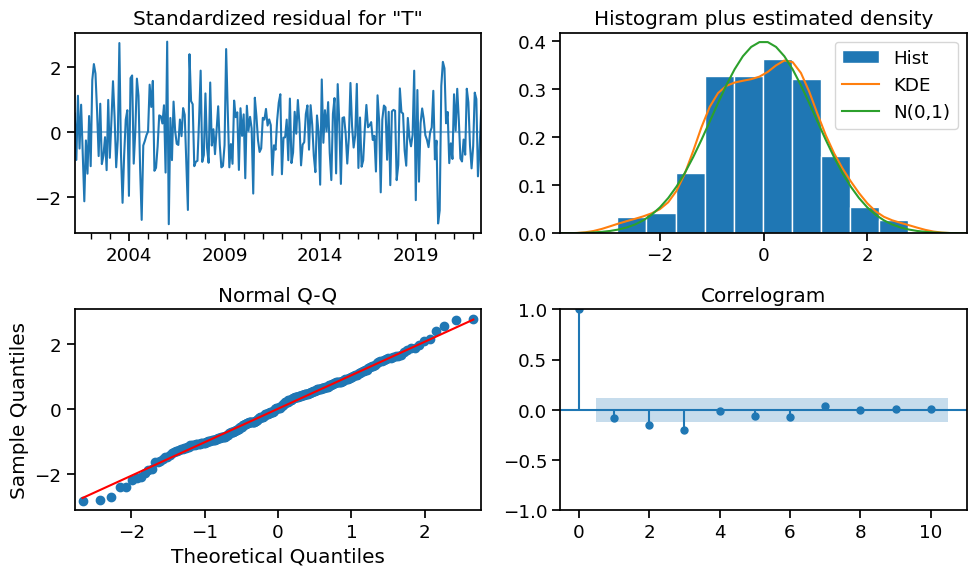

In [77]:
# Obtain diagnostic plots
fig = auto_sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 662.961
- MSE = 563,734.239
- RMSE = 750.822
- R^2 = -2.194
- MAPE = 13.72%


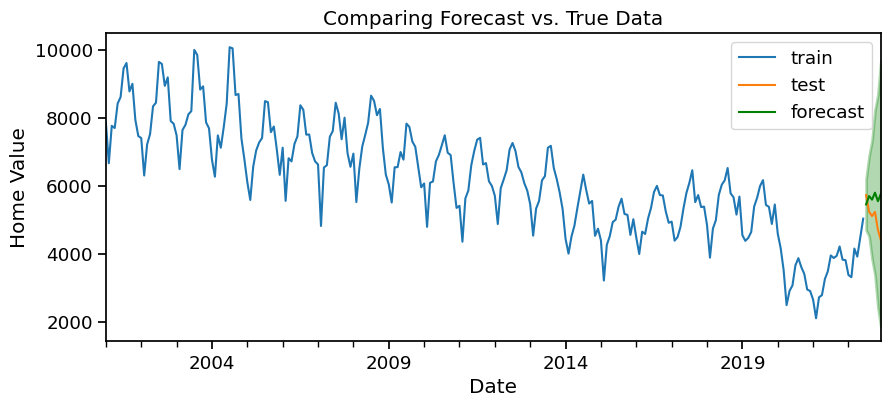

In [78]:
# Obtain summary of forecast as dataframe
forecast_df2 = auto_sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df2)

# Obtain metrics
regression_metrics_ts(test, forecast_df2["mean"])

## Final Model

The manual chosen manual model outperforms the tuned model on all metrics and will be used as the final model.

In [80]:
# Orders for non seasonal components
p = 1 # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1 # nonseasonal MA

P = 1
D = 0
Q = 1
m = 12


final_model = tsa.ARIMA(ts_theft, order = (p,d,q), seasonal_order = (P,D,Q,m)).fit()  

# Obtain model summary
final_model.summary()

C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lovei\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  264
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1928.065
Date:                          Thu, 30 Nov 2023   AIC                           3866.131
Time:                                  21:45:55   BIC                           3883.992
Sample:                              01-01-2001   HQIC                          3873.309
                                   - 12-01-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.328      3.045      0.002       0.356       1.643
ma.L1         -0.9998      0.376     -2.657      0.008      -1.737      -0.262
ar.S.L12       0.9840      0.004    259.038      0.000       0.977       0.991
ma.S.L12      -0.6910      0.029    -24.135      0.000      -0.747      -0.635
sigma2      7.671e+04   5.84e-05   1.31e+09      0.000    7.67e+04    7.67e+04
===================================================================================
Ljung-Box (L1) (Q):                  13.01   Jarque-Bera (JB):                13.12
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.24
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+23. Standard errors may be unstable.
"""

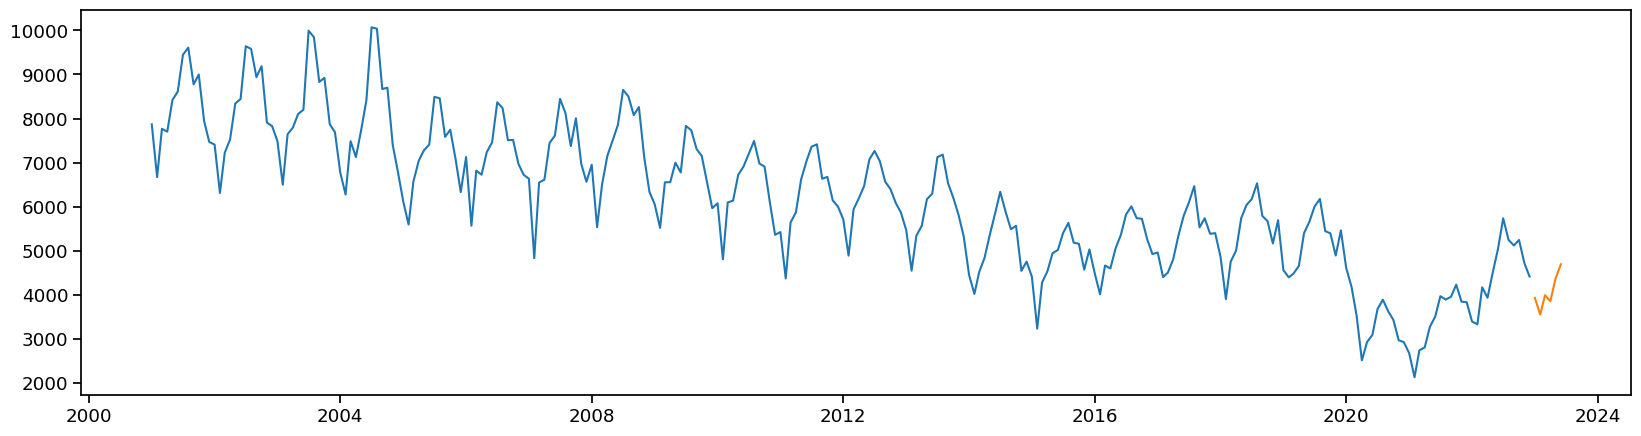

In [82]:
# define forecast with 6 steps forward
forecast_df = final_model.get_forecast(steps=6).summary_frame() # collabed during office hours
# plot data plus forcast
plt.plot(ts_theft)
plt.plot(forecast_df['mean']);

In [89]:
# define forecast end/beginning value
end_pred = round(forecast_df['mean'].iloc[-1])
beg_pred = round(forecast_df['mean'].iloc[0])
end_pred, beg_pred

(4689, 3926)

In [91]:
# define difference between end forecast and end true
diff = end_pred - beg_pred
# define percentage change
percent_diff = (diff/beg_pred)*100
diff, percent_diff

(763, 19.434538970962812)

In [94]:
print(f'There is an increase in the raw counts of theft crimes in the forecasted data by {diff}, which is a pertentage change of {percent_diff}.')

There is an increase in the raw counts of theft crimes in the forecasted data by 763, which is a pertentage change of 19.434538970962812.


# **BATTERY**